In [1]:
%matplotlib inline
import pymongo

import numpy as np
import pandas as pd

import seaborn as sns
# import bokeh
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Configuration of the database
client = pymongo.MongoClient("mongodb://localhost:27017/")
database = client['thesis']
db_dumps = database['dumps']
db_boards = database['boards']

# List of recurring data
boards_ids = list(set(i['board_id'] for i in db_dumps.find({},{"_id": 0, "board_id": 1})))

print("Number of boards: " + str(len(boards_ids)))

Number of boards: 67


In [3]:
# Configuration of matplotlib
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=15) 
plt.rc('figure', titlesize=18)

plt.rcParams['figure.figsize'] = [29, 10]  # Scale up plots 

# Configuration of data frames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
def add_to_off(address, starting_address=0x20000000, dump_size=512):
    '''Convert a memory address into an index.'''
    if isinstance(address, str):
        address = int(mem_address, 16)
    if isinstance(starting_address, str):
        starting_address = int(starting_address, 16)
        
    return (address - starting_address) // dump_size


def off_to_add(offset, starting_address=0x20000000, dump_size=512):
    '''Convert an offset into a memory address.'''
    if isinstance(starting_address, str):
        starting_address = int(starting_address, 16)
        
    return hex(offset * dump_size + starting_address)

In [19]:
import multiprocessing as mp

def parallelize_call_ma(func, func_args, pool_count=mp.cpu_count()):
    '''Use multiprocessing to parallelize the call to func'''
    pool = mp.Pool(pool_count)
    results = [pool.map_async(func, func_args)] 
    pool.close()  
    pool.join()
    
    return [p.get() for p in results]

In [20]:
# Extract useful data from the board id
extracted_id_cols = ['Board', 'Wafer', 'Lot', 'X', 'Y']

extracted_id_df = pd.DataFrame(columns=extracted_id_cols)

for board_id in boards_ids:
    data = {'Board': board_id,
            'Wafer': board_id[2:4],
            'Lot': board_id[4:18],
            'X': int(board_id[21:23], 16),
            'Y': int(board_id[18:20], 16)}
    
    # Insert the extracted data into another collection
    # db_boards.insert_one(data) 
    extracted_id_df = extracted_id_df.append(data, ignore_index=True)


# Sort the data frame and show it
extracted_id_df.sort_values(['Wafer', 'X', 'Y'], ascending=[True, True, True], inplace=True)
extracted_id_df

,Board,Wafer,Lot,X,Y
17,0x30314710303537322F80380,30,31471030353732,3,47
53,0x30314719373435342D01C0,30,31471937343534,28,45
10,0x3031471737343534440230,30,31471737343534,35,68
65,0x30314717373435343F02A0,30,31471737343534,42,63
27,0x30314718373435342A02B0,30,31471837343534,43,42
51,0x30314718373435343F02E0,30,31471837343534,46,63
15,0x30314710303537323E0372,30,31471030353732,55,62
5,0x30314710303537323E03A0,30,31471030353732,58,62
55,0x30314717373435343003E0,30,31471737343534,62,48
57,0x30314717373435344703E0,30,31471737343534,62,71


In [21]:
def plot_memory_regions(board_id, offset=0, mem_ending_pos=32, chunk_size=512, show_every=False):
    '''
    Given a board id, make a scatter plot of the specified memory dumps.
    X axis is the direction and the y axis is the value at that position.
    ''' 
    
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    database = client['thesis']
    db_dumps = database['dumps']

    mem_pos, mem_off, mem_val = [], [], []
    
    dumps_list = list(db_dumps.find({"board_id": board_id}))
    
    for plot in range(offset, mem_ending_pos):
        mem_val = dumps_list[plot]['data']
        mem_off = dumps_list[plot]['mem_pos']
        mem_pos = [int(mem_off, 16) + i for i in range(0, chunk_size)]

        # Generate the plot
        plt.scatter(mem_pos, mem_val, marker='x')
        plt.xlabel('Memory address')
        plt.ylabel('Values')
                         
        if show_every:
            plt.title('[' + board_id + '] Memory map at ' + str(mem_off))
        else:
            starting_address = off_to_add(offset)
            ending_address = off_to_add(mem_ending_pos)
            plt.title('[' + board_id + '] Memory map from ' + \
                      str(starting_address) + ' to ' + str(ending_address))
            
        ax = plt.gca()
        plt.ylim((0, 270))
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(16))
        ax.yaxis.set_major_locator(plt.MaxNLocator(25))
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

        xlabels = map(lambda t: '0x%08X' % int(t), ax.get_xticks())  # Show x axis as hex numbers
        ax.set_xticklabels(xlabels, rotation=45, horizontalalignment='right');
        
        plt.grid()
        
        # Show every plot or all of the data combined in one
        if show_every:
            plt.show()

In [22]:
from itertools import combinations

def calculate_diff(sample1, sample2):
    '''
    Given two dumps of data, calculate the difference between their data.
    '''
    diff = 0
    length = min(sample1['length'], sample2['length'])
    
    for i in range(length):
        if sample1['data'][i] != sample2['data'][i]:
            diff = diff + 1
    
    diff = diff / int(sample1['length'])
    return (diff * 100)


def compare_dumps_one_board(board_id, df=None, board_dumps=[]):
    '''
    Given a pair of dumps of a board, calculate the difference in % between them.
    Outputs a data frame with the board_id, the memory position
    and the difference in % between the samples.
    '''
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    database = client['thesis']
    db_dumps = database['dumps']
    db_comps = database['comps']
    
    memory_groups = []
    
    if df is None:
        column_names = ["Board", "Region", "Id_1", "Id_2", "Diff"]
        df = pd.DataFrame(columns=column_names)
    
    if not board_dumps:
        board_dumps = db_dumps.find({"board_id": board_id})
    
    # Every possible starting memory address
    memory_regions = list(set([mem_pos['mem_pos'] for mem_pos in board_dumps]))
    
    # There are 32 groups, one per region of memory
    for region in memory_regions:
        
        samples = list(db_dumps.find({"mem_pos": region, "board_id": board_id}))
        region_samples = list(combinations(samples, 2))
        
        # Cycle through all of the samples of that memory region
        for i, (sample1, sample2) in enumerate(region_samples):
            diff = calculate_diff(sample1, sample2)
                
            data = {'Board': board_id,
                    'Region': region,
                    'Id_1': str(sample1['_id']),
                    'Id_2': str(sample2['_id']),
                    'Diff': diff}
            # db_comps.insert_one(data)
            df = df.append(data, ignore_index=True)

    return df


def filter_results_df(data_frame, lower_thresh, upper_thresh, column='Diff'):
    '''
    Filter the results of a data frame.
    The new data frame has values between the given thresholds.
    '''
    is_valid = data_frame[column] > lower_thresh
    data_frame = data_frame[is_valid]
    
    is_valid = data_frame[column] < upper_thresh
    data_frame = data_frame[is_valid]
    
    return data_frame

In [23]:
# Loop over all the boards and calculate the diff in their data
# Filter out the ones that are too high or too low

column_names = ["Board", "Region", "Id_1", "Id_2", "Diff"]

final_df = pd.DataFrame(columns=column_names) # To handle final results

for bid in boards_ids[3:]:
    df = pd.DataFrame(columns=column_names)
    data = compare_dumps_one_board(bid, df)
    data_valid = filter_results_df(data, 5, 50)
    
    final_df = final_df.append(data_valid, ignore_index=True)

# Regions of memory with the differences that we want
good_regions = list(set(final_df['Region']))
good_df = pd.DataFrame(columns=['Region', 'Mean_Diff', 'Deviation'])

# Iterate over all these regions and calculate the mean diff
# for all the boards
for region in good_regions:
    region_selector = final_df['Region'] == region
    region_df = final_df[region_selector]

    good_df = good_df.append({'Region': region,
                              'Num_Samples': len(region_df.index),
                              'Mean_Diff': region_df['Diff'].mean(),
                              'Deviation': region_df['Diff'].std()},
                             ignore_index=True)
    


In [24]:
good_df.sort_values(['Mean_Diff'], ascending=[True], inplace=True)

good_df

,Region,Mean_Diff,Deviation,Num_Samples
26,0x20000600,20.147429,12.882958,155.0
25,0x20003e00,24.470215,3.334005,160.0
4,0x20002000,27.589286,4.662080,105.0
3,0x20000c00,27.853423,6.585910,105.0
19,0x20002e00,28.350074,5.154604,105.0
12,0x20003200,28.413318,5.999556,105.0
11,0x20003000,28.565848,5.416996,105.0
14,0x20001400,28.722098,4.892031,105.0
16,0x20003c00,28.832784,7.857931,109.0
13,0x20001600,28.921131,5.169661,105.0


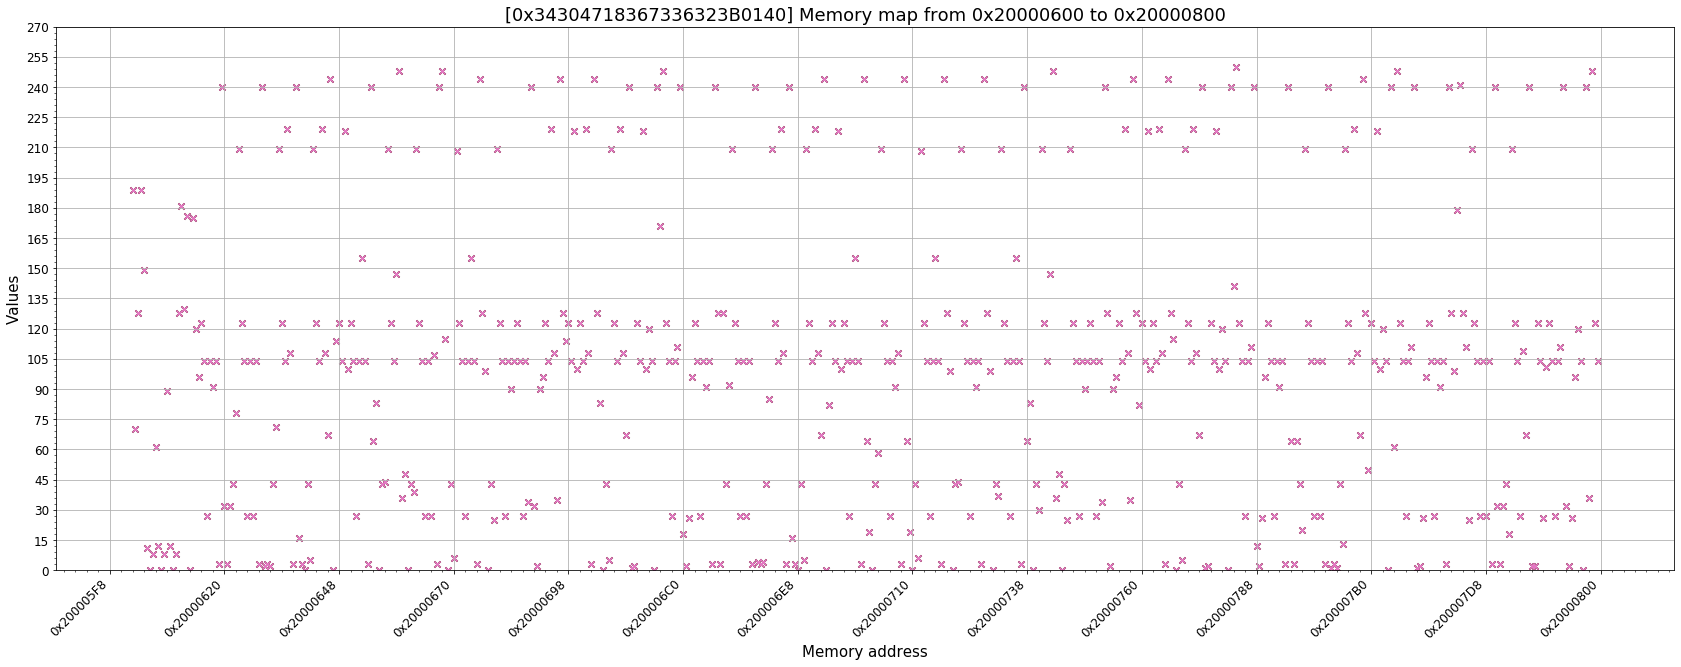

In [25]:
for bid in boards_ids[0:7]:
    plot_memory_regions(bid, add_to_off(0x20000600), add_to_off(0x20000600) + 1, show_every=False)

In [26]:
# Compare the same memory region in different boards

# memory_regions_uut = list(set([mem_pos['mem_pos'] for mem_pos in board_dumps]))
# final_column_names = ["Board_1", "Board_2", "Region", "Id_1", "Id_2", "Diff"]

# fdata_df = pd.DataFrame(columns=final_column_names)
    
# for region_uut in memory_regions_uut:
#     dumps_board_0 = list(db_dumps.find({'mem_pos': region_uut, 'board_id': boards_ids[0]}))
#     dumps_board_1 = list(db_dumps.find({'mem_pos': region_uut, 'board_id': boards_ids[1]}))

#     num_samples = min(len(dumps_board_0), len(dumps_board_1))

#     for sample in range(num_samples):
#         diff = calculate_diff_one_board(dumps_board_0[sample], dumps_board_1[sample])
    
#         data = {'Board_1': dumps_board_0[sample]['board_id'],
#                 'Board_2': dumps_board_1[sample]['board_id'],
#                 'Region': region_uut,
#                 'Id_1': str(dumps_board_0[sample]['_id']),
#                 'Id_2': str(dumps_board_1[sample]['_id']),
#                 'Diff': diff}
    
#         fdata_df = fdata_df.append(data, ignore_index=True)

# final_is_valid = fdata_df['Diff'] < 70
# fdata_df = fdata_df[final_is_valid]

# fdata_df.sort_values(['Diff'], ascending=[True], inplace=True)
# fdata_df

In [ ]:
# Compare all memory regions in all of the boards
# Filter only the ones with a low difference
#
# boards_dumps_df holds all the dump differences of the same
# board which are in the good range

column_names = ["Board", "Region", "Id_1", "Id_2", "Diff"]
boards_dumps_df = pd.DataFrame(columns=column_names)

output = parallelize_call_ma(compare_dumps_one_board, boards_ids[2:])

for o_df in output[0]:
    o_df = filter_results_df(o_df, 5, 21)
    boards_dumps_df = boards_dumps_df.append(o_df, ignore_index=True)

In [218]:
print(f'Number of results: {len(boards_dumps_df.index)}')
boards_dumps_df.head(10)

Number of results: 367


,Board,Region,Id_1,Id_2,Diff
0,0x343047A367336324402D0,0x20000600,5dbb0b4b330b053b8318d29d,5dbb0b56330b053b8318d2bd,14.257812
1,0x343047A367336324402D0,0x20003e00,5dbb0b43330b053b8318d299,5dbb0b5a330b053b8318d2d9,19.921875
2,0x3430473367336322523F0,0x20003e00,5dbafe4ca710478051e8192b,5dbafe81a710478051e8194b,20.507812
3,0x3430473367336322523F0,0x20003e00,5dbafe81a710478051e8194b,5dbafe9fa710478051e8196b,20.312500
4,0x30314710303537323E03A0,0x20000600,5dbb07d5706c1c4902b28b54,5dbb0875706c1c4902b28c34,8.789062
5,0x30314710303537323E03A0,0x20001200,5dbb07d5706c1c4902b28b5a,5dbb0876706c1c4902b28c3a,19.140625
6,0x30314710303537323E03A0,0x20001600,5dbb07d6706c1c4902b28b5c,5dbb0876706c1c4902b28c3c,20.898438
7,0x30314710303537323E03A0,0x20001000,5dbb07d5706c1c4902b28b59,5dbb0876706c1c4902b28c39,16.601562
8,0x30314710303537323E03A0,0x20003400,5dbb07d7706c1c4902b28b6b,5dbb0878706c1c4902b28c4b,20.312500
9,0x30314710303537323E03A0,0x20003000,5dbb07d7706c1c4902b28b69,5dbb0877706c1c4902b28c49,20.312500


In [224]:
# Calculate the mean and std_deviation of the diff from
# the data frame with the data in the range we desire

boards_umt_df = boards_dumps_df

# Not all boards are within the good range we want
good_boards = list(set(boards_umt_df['Board']))
good_regions = list(set(boards_umt_df['Region']))

print(f'Number of boards: {len(good_boards)}')
print(f'Regions of interest [{len(good_regions)}]: {good_regions}')

mean_df = pd.DataFrame(columns=['Board', 'Region', 'Num_Samples', 'Mean_Diff', 'Deviation'])

# Iterate over all the good boards
for gb in good_boards:
    
    board_selector = boards_umt_df['Board'] == gb
    board_ut_df = boards_umt_df[board_selector]
    mem_regions = list(set(board_ut_df['Region']))
    
    # Iterate over the good regions of the board
    for region in mem_regions:
        region_selector = board_ut_df['Region'] == region
        board_region_df = board_ut_df[region_selector]
            
        data = {'Board': gb,
                'Region': region,
                'Num_Samples': len(board_region_df.index),
                'Mean_Diff': board_region_df['Diff'].mean(),
                'Deviation': board_region_df['Diff'].std()}
        
        mean_df = mean_df.append(data, ignore_index=True)

Number of boards: 11
Regions of interest [25]: ['0x20001800', '0x20001a00', '0x20002a00', '0x20000600', '0x20001200', '0x20001600', '0x20001000', '0x20003800', '0x20003400', '0x20003000', '0x20003200', '0x20000e00', '0x20001c00', '0x20003e00', '0x20000800', '0x20000a00', '0x20003a00', '0x20002e00', '0x20001e00', '0x20000c00', '0x20002800', '0x20002000', '0x20001400', '0x20002c00', '0x20003c00']


In [226]:
mean_df.sort_values(['Board', 'Region'], ascending=[True, True], inplace=True)
print(f'Number of results: {len(mean_df.index)}')
mean_df

Number of results: 51


,Board,Region,Num_Samples,Mean_Diff,Deviation
6,0x30314710303537323E0372,0x20000600,34,8.978631,0.660126
17,0x30314710303537323E0372,0x20000800,25,19.835938,0.936822
18,0x30314710303537323E0372,0x20000a00,10,20.039062,0.505973
22,0x30314710303537323E0372,0x20000c00,28,19.294085,1.518809
14,0x30314710303537323E0372,0x20000e00,17,19.772518,0.712721
9,0x30314710303537323E0372,0x20001000,10,19.804688,0.480185
7,0x30314710303537323E0372,0x20001200,13,20.177284,0.512949
25,0x30314710303537323E0372,0x20001400,4,20.703125,0.000000
8,0x30314710303537323E0372,0x20001600,3,20.312500,0.000000
3,0x30314710303537323E0372,0x20001800,2,19.140625,0.000000


In [ ]:
# TODO: Make a heatmap with the mean and deviation of the memory of a board to show how it changes